In [1]:
## Define local path
cd("../")

LOCAL_PATH = pwd()

;

In [2]:
LOCAL_PATH

"/home/leonardo/Documents/data_matteo"

In [3]:
## Include packages

#using Distributed 
using DelimitedFiles
#using GaussDCA
#using PlmDCA
using DCAUtils
using Plots
using StatsPlots
using FastaIO
using StatsBase
using Printf
using LinearAlgebra
using MultivariateStats
#using GLM
using Statistics
using KitMSA
include("src/Basic_code/contact_prediction.jl")
include("src/Basic_code/read_write.jl")
include("src/Basic_code/energy.jl")
include("src/Basic_code/msa_tools.jl")
include("src/Basic_code/evol.jl")
include("src/Basic_code/extra_tools.jl")
include("src/Basic_code/plotscode.jl")
;

In [4]:
PATH_PAR_dbd = "../data_matteo/model_parameters/Parameters_conv_Thr-PCD40.dat"
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
maximum(J)


1.959042

In [5]:
function dms_Potts(reff, h, J)
    N = length(reff)
    ens = []
    E_ref = compute_energy_single_sequence(h, J, reff) 
    for pos in 1:length(reff)
        for amino in 1:21
            if amino != reff[pos]
                seq = deepcopy(reff)
                seq[pos] = amino
                push!(ens, compute_energy_single_sequence(h, J, seq) - E_ref)
            end
        end
    end
    return ens
end

function compute_energy_profile(h::Array{Float64,2},
                                        S::Vector)
    N = size(h)[2]
    q = size(h)[1]
    E = 0.0
    for i = 1:N
        E -= h[S[i],i]
	end
return E
end


function dms_profile(reff, freqs)
    N = length(reff)
    ens = []
    for pos in 1:length(reff)
        for amino in 1:21
            if amino != reff[pos]
                push!(ens, log(freqs[reff[pos]]/freqs[q+(pos-1)*amino ])
            end
        end
    end
    return ens
end


LoadError: syntax: missing comma or ) in argument list

In [6]:
function cond_proba(k, mutated_seq, h, J,N,  T = 1)
	prob = zeros(21)
	for i in 1:21
        q_k = i
        log_proba = h[q_k, k]
        for j in 1:N
            log_proba += J[mutated_seq[j], q_k , j, k]
        end
        prob[i] = exp(log_proba/T)     
	end
    res = normalize(prob,1) 
    real_res = zeros(20)
    idx = 0
    for i in 1:21
        if i != mutated_seq[k]
            idx+=1
            real_res[idx]= res[i]
        end
    end
	return real_res
end

function cond_proba_with_deg(k, mutated_seq, h, J,N,  T = 1)
	prob = zeros(21)
	for i in 1:21
        q_k = i
        log_proba = h[q_k, k] - T*log(length(amino2cod[q_k]))
        for j in 1:N
            log_proba += J[mutated_seq[j], q_k , j, k]
        end
        prob[i] = exp(log_proba/T)     
	end
    res = normalize(prob,1) 
    real_res = zeros(20)
    idx = 0
    for i in 1:21
        if i != mutated_seq[k]
            idx+=1
            real_res[idx]= res[i]
        end
    end
	return real_res
end


cond_proba_with_deg (generic function with 2 methods)

In [7]:
function proba_DNA_gibbs(k, mutated_seq, h, J,N,  T = 1)
	prob = zeros(20)
	for i in 1:20
        q_k = i
		log_proba = h[q_k, k]
 		for j in 1:N
			log_proba += J[mutated_seq[j], q_k , j, k]
		end
		prob[i] = exp(log_proba/T)
	end
	return normalize(prob,1)
    
end

function cont_dep_entr(background, h, J)
    
    T = 1.0
    N = length(background)
    
    prob = hcat([ProbabilityWeights(proba_DNA_gibbs(pos_mut, background, h, J, N, T)) for pos_mut in 1:N]...)
    #println(size(prob))
    return get_entropy(prob)
end
    
function find_first_occurrence_indices(mut_taus, numbers)
    index_dict = Dict{Int, Int}()
    
    res = deepcopy(mut_taus)
    for (i, num) in enumerate(numbers)
        if haskey(index_dict, num)
            continue
        end
        index_dict[num] = i
    end
    
    # Print the results
    for (num, index) in index_dict
        #println("$num first appears at index $index")
        res[num]=index
    end

    return res
end


find_first_occurrence_indices (generic function with 1 method)

In [8]:
function get_times_new_way(folder_path)
    
    fasta_files = filter(file -> endswith(file, ".mixedDNA.txt"), readdir(folder_path))
    #matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) 
        #for file in fasta_files]
    
    
    n_chains = length(fasta_files)
    
    matrices = Int8.(fasta2matrix(joinpath(folder_path, fasta_files[1])))
    start_seq = matrices[1,:]
    tot_T = length(matrices[:,1])
    mut_taus = [tot_T for s in 1:21]
    L = length(start_seq)
    
    times = []
    
    for n in 1:n_chains
        matrices = Int8.(fasta2matrix(joinpath(folder_path, fasta_files[n])))
        println(n)
        taus = Matrix{Float64}(undef, 21, L)
        for i in 1:L
            result = find_first_occurrence_indices(mut_taus, matrices[:,i])
            taus[:,i] = result
        end
        push!(times, taus)
    end
    
    return  hcat([filter(x -> x != 1, arr) for arr in times]...)
end
      

function pseudocount_with_gap(f)
    f1=(1-10^-4)*f.+10^-4/21
    return f1
end


pseudocount_with_gap (generic function with 1 method)

In [19]:
#folder_path = "../data_matteo/data/mini_sample_sabri/"
folder_path = "../data_matteo/data/files_amino_mixed_dbd_steps500000_seqs500_T1.0p0.5/"
fasta_files = filter(file -> endswith(file, ".mixedDNA.txt"), readdir(folder_path))
@time times = get_times_new_way(folder_path)
;

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [75]:
times = readdlm("../data_matteo/my_project/images/dms_predict_mut_time/times",
'\t')
;
     

In [76]:
times

1520×500 Matrix{Float64}:
 500001.0  500001.0  500001.0  500001.0  …  500001.0  500001.0  500001.0
 500001.0  500001.0  500001.0  500001.0     500001.0  500001.0  371194.0
 500001.0  500001.0  500001.0  500001.0     500001.0  500001.0  371070.0
 500001.0  500001.0  500001.0  500001.0     500001.0  500001.0  500001.0
 500001.0  500001.0  500001.0  500001.0     500001.0  500001.0  500001.0
 500001.0  500001.0  500001.0  500001.0  …  500001.0  500001.0  370571.0
 500001.0  500001.0  500001.0  500001.0     500001.0  500001.0  500001.0
 500001.0  500001.0  500001.0  500001.0     500001.0  500001.0  500001.0
 500001.0  500001.0  500001.0  500001.0     500001.0  500001.0  500001.0
 500001.0  500001.0  500001.0  500001.0     500001.0  500001.0  500001.0
 500001.0  500001.0  500001.0  500001.0  …  500001.0  500001.0  500001.0
 500001.0  500001.0  500001.0  500001.0     500001.0  500001.0  500001.0
 500001.0  500001.0  500001.0  500001.0     500001.0  500001.0  370670.0
      ⋮                  

In [11]:
@time first_ref, second_ref = compute_weighted_frequencies(Int8.(nat_MSA'), 0.2)
;

LoadError: UndefVarError: `nat_MSA` not defined

In [264]:
gap_f = 1 .- [sum(first_ref[1+(i-1)*20:i*20]) for i in 1:length(start_seq)]
correct_f = []  
for pos in 1:length(start_seq)
    for q in 1:21
        #if q != start_seq[pos] && q !=21
        if q !=21
            push!(correct_f, first_ref[q+(pos-1)*20])
        end   
        #if q != start_seq[pos] && q ==21
        if q == 21
            push!(correct_f, gap_f[pos])
        end
    end
end



new_arr = vec(hcat([pseudocount_with_gap(correct_f[1+(i-1)*21:i*21]) 
        for i in 1:length(start_seq)]...))


println(sum([sum(new_arr[1+(i-1)*21:i*21]) for i in 1:76]))            

76.0


In [268]:
f_a = []
for pos in 1:length(start_seq)
    for q in 1:21
        if q != start_seq[pos]
            push!(f_a, new_arr[q+(pos-1)*21])
        end   
    end
end

f_ai = []
for i in 1:length(start_seq)
    for q in 1:20
        push!(f_ai, new_arr[start_seq[i]+(i-1)*21])
    end
end

In [12]:
sat = times .== 500001 
sat_ab = sum(sat, dims = 2)[:] ./ 500
;

In [14]:
folder_path = "../data_matteo/data/files_amino_mixed_dbd_steps500000_seqs500_T1.0p0.5/"
nat_MSA = Int8.(fasta2matrix("../data_matteo/alignments/natural/DBD_alignment.uniref90.cov80.a2m"))
start_seq = Int8.(fasta2matrix(joinpath(folder_path, 
            "equil_det_bal_dbd_silico_chain_num_1_T_1.0.mixedDNA.txt" )))[1,:]
L = length(start_seq)
freqs_nat = reshape(pseudocount(first_stat(nat_MSA)), (20, L))
cie = get_entropy(freqs_nat)
cde = cont_dep_entr(start_seq, h, J)
epis_score = abs.(cie .- cde)

;

In [140]:
median_times = median(times, dims=2)[:]
dEs = Float64.(dms_Potts(start_seq, h, J))
#dEs_profile = log.(f_ai./f_a)
Y = times # Y is now a matrix of random values

# Calculate the median, Q1, and Q3 for each set of y points
Ym = median(Y, dims=2)[:]
X = dEs
;

In [18]:




n = length(X)
colors_cde = vcat([[cde[i] for j in 1:20] for i in 1:length(start_seq)]...)
colors_epis = vcat([[epis_score[i] for j in 1:20] for i in 1:length(start_seq)]...)
colors_cie = vcat([[cie[i] for j in 1:20] for i in 1:length(start_seq)]...)

q1 = [quantile(Y[i,:], 0.25) for i in 1:n]
q3 = [quantile(Y[i,:], 0.75) for i in 1:n]


# Calculate the error bars
eps_d = Ym .- q1
eps_u= q3 .- Ym

corr = round.(corspearman(X, Ym), digits = 2)


0.87

In [295]:
scatter(X, Ym./exp.(X), zcolor=colors_cie, yscale=:log10,
    xlabel = "dE(a_i->a)", label = "Spearman $corr", 
    ylabel = "Tau/exp(dE)", colorbar_title = "CIE")
savefig("../data_matteo/my_project/images/newdmspredictcie.png")

scatter(X, Ym./exp.(X), zcolor=colors_cde, yscale=:log10,
    xlabel = "dE(a_i->a)",  label = "Spearman $corr", 
    ylabel = "Tau/exp(dE)", colorbar_title = "CDE (t=0)")
savefig("../data_matteo/my_project/images/newdmspredictcde.png")

scatter(X, Ym./exp.(X), zcolor=colors_epis, yscale=:log10,
    xlabel = "dE(a_i->a)",  label = "Spearman $corr",
    ylabel = "Tau/exp(dE)", colorbar_title = "|CIE-CDE|")
savefig("../data_matteo/my_project/images/newdmspredictepis.png")

"/home/leonardo/Documents/data_matteo/my_project/images/newdmspredictepis.png"

In [296]:


scatter(X, Ym, zcolor=colors_cie, yerror=(eps_d, eps_u),
    xlabel = "dE(a_i->a)", yscale=:log10, label = "Spearman $corr", 
    ylabel = "Mut time (MCMC steps)", colorbar_title = "CIE")
savefig("../data_matteo/my_project/images/dmspredictcie.png")

scatter(X, Ym, zcolor=colors_cde, yerror=(eps_d, eps_u),
    xlabel = "dE(a_i->a)", yscale=:log10, label = "Spearman $corr", 
    ylabel = "Mut time (MCMC steps)", colorbar_title = "CDE (t=0)")
savefig("../data_matteo/my_project/images/dmspredictcde.png")

scatter(X, Ym, zcolor=colors_epis, yerror=(eps_d, eps_u), 
    xlabel = "dE(a_i->a)", yscale=:log10, label = "Spearman $corr", 
    ylabel = "Mut time (MCMC steps)", colorbar_title = "|CIE-CDE|")
savefig("../data_matteo/my_project/images/dmspredictepis.png")

"/home/leonardo/Documents/data_matteo/my_project/images/dmspredictepis.png"

0.8302592212443173


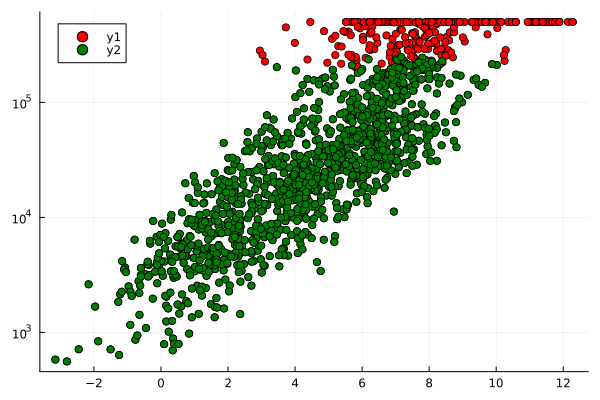

In [92]:
tresh = 0.2
println(corspearman(X[sat_ab .< tresh], median_times[sat_ab .< tresh]))
scatter(X, median_times, yscale =:log10, color=:red)
scatter!(X[sat_ab .< tresh], median_times[sat_ab .< tresh],
    yscale =:log10, color=:green)



In [120]:
tresh = 0.2 
mask = sat_ab .< tresh
deg = 1 .- [length(amino2cod[aa]) for aa in start_seq]./12
non_syn = vcat([[deg[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)

L = length(start_seq)
#including nucleotides
@time rho = 0.5 .* non_syn .* vec(hcat([cond_proba_with_deg(i, start_seq, h, J, L) 
            for i in 1:L]...)) ./ L 
#non-including nucleotides
#@time rho = vec(hcat([cond_proba(i, start_seq, h, J, L) for i in 1:L]...)) ./ L 

T_th = abs.(log(2) ./ log.(1 .- rho))

X_filt = X[mask]
Ym_filt = Ym[mask]
T_th_filt = T_th[mask]

corr = round.(corspearman(X_filt, Ym_filt), digits = 2)

colors_cde_filt = vcat([[cde[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]
colors_epis_filt = vcat([[epis_score[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]
colors_cie_filt = vcat([[cie[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]



scatter(X_filt, Ym_filt./T_th_filt, zcolor=colors_cie_filt, yscale=:log10,
    xlabel = "dE(a_i->a)", label = "Spearman $corr", 
    ylabel = "Tau/T_th", colorbar_title = "CIE")
savefig("../data_matteo/my_project/images/$(tresh)Tthdmspredictcie.png")

scatter(X_filt, Ym_filt./T_th_filt, zcolor=colors_cde_filt, yscale=:log10,
    xlabel = "dE(a_i->a)",  label = "Spearman $corr", 
    ylabel = "Tau/T_th", colorbar_title = "CDE (t=0)")
savefig("../data_matteo/my_project/images/$(tresh)Tthnewdmspredictcde.png")

scatter(X_filt, Ym_filt./T_th_filt, zcolor=colors_epis_filt, yscale=:log10,
    xlabel = "dE(a_i->a)",  label = "Spearman $corr",
    ylabel = "Tau/T_th", colorbar_title = "|CIE-CDE|")
savefig("../data_matteo/my_project/images/$(tresh)Tthnewdmspredictepis.png")

  0.342692 seconds (341.64 k allocations: 9.661 MiB, 88.19% compilation time)


"/home/leonardo/Documents/data_matteo/my_project/images/0.2Tthnewdmspredictepis.png"

In [126]:
tresh = 0.2 
mask1 = sat_ab .< tresh
mask2 = aa_dist .==1

mask = mask1 .& mask2
deg = 1 .- [length(amino2cod[aa]) for aa in start_seq]./12
non_syn = vcat([[deg[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)

L = length(start_seq)
#including nucleotides
@time rho = 0.5 .* non_syn .* vec(hcat([cond_proba_with_deg(i, start_seq, h, J, L) 
            for i in 1:L]...)) ./ L 
#non-including nucleotides
#@time rho = vec(hcat([cond_proba(i, start_seq, h, J, L) for i in 1:L]...)) ./ L 

T_th = abs.(log(2) ./ log.(1 .- rho))

X_filt = X[mask]
Ym_filt = Ym[mask]
T_th_filt = T_th[mask]

corr = round.(corspearman(X_filt, Ym_filt), digits = 2)

colors_cde_filt = vcat([[cde[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]
colors_epis_filt = vcat([[epis_score[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]
colors_cie_filt = vcat([[cie[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]



scatter(X_filt, Ym_filt./T_th_filt, zcolor=colors_cie_filt, yscale=:log10,
    xlabel = "dE(a_i->a)", label = "Spearman $corr", 
    ylabel = "Tau/T_th", colorbar_title = "CIE")
savefig("../data_matteo/my_project/images/$(tresh)Tthdmspredictcie.png")

scatter(X_filt, Ym_filt./T_th_filt, zcolor=colors_cde_filt, yscale=:log10,
    xlabel = "dE(a_i->a)",  label = "Spearman $corr", 
    ylabel = "Tau/T_th", colorbar_title = "CDE (t=0)")
savefig("../data_matteo/my_project/images/$(tresh)Tthnewdmspredictcde.png")

scatter(X_filt, Ym_filt./T_th_filt, zcolor=colors_epis_filt, yscale=:log10,
    xlabel = "dE(a_i->a)",  label = "Spearman $corr",
    ylabel = "Tau/T_th", colorbar_title = "|CIE-CDE|")
savefig("../data_matteo/my_project/images/$(tresh)Tthnewdmspredictepis.png")

  0.154040 seconds (276.01 k allocations: 5.505 MiB, 69.20% compilation time)


"/home/leonardo/Documents/data_matteo/my_project/images/0.2Tthnewdmspredictepis.png"

In [430]:
tresh = 0.2
mask = sat_ab .< tresh

L = length(start_seq)
@time rho = vec(hcat([cond_proba_with_deg(i, start_seq, h, J, L) for i in 1:L]...)) ./ L 
T_th = abs.(log(2) ./ log.(1 .- rho))


X_filt = dEs_profile[mask]
Ym_filt = Ym[mask]
T_th_filt = T_th[mask]

corr = round.(corspearman(X_filt, Ym_filt), digits = 2)

colors_cde_filt = vcat([[cde[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]
colors_epis_filt = vcat([[epis_score[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]
colors_cie_filt = vcat([[cie[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]

scatter(X_filt, Ym_filt./T_th_filt, zcolor=colors_cie_filt, yscale=:log10,
    xlabel = "dE(a_i->a)", label = "Spearman $corr", 
    ylabel = "Tau/T_th", colorbar_title = "CIE")
savefig("../data_matteo/my_project/images/prof$(tresh)Tthdmspredictcie.png")

scatter(X_filt, Ym_filt./T_th_filt, zcolor=colors_cde_filt, yscale=:log10,
    xlabel = "dE(a_i->a)",  label = "Spearman $corr", 
    ylabel = "Tau/T_th", colorbar_title = "CDE (t=0)")
savefig("../data_matteo/my_project/images/prof$(tresh)Tthnewdmspredictcde.png")

scatter(X_filt, Ym_filt./T_th_filt, zcolor=colors_epis_filt, yscale=:log10,
    xlabel = "dE(a_i->a)",  label = "Spearman $corr",
    ylabel = "Tau/T_th", colorbar_title = "|CIE-CDE|")
savefig("../data_matteo/my_project/images/prof$(tresh)Tthnewdmspredictepis.png")

  0.102481 seconds (23.83 k allocations: 1.658 MiB, 90.20% compilation time)


"/home/leonardo/Documents/data_matteo/my_project/images/prof0.2Tthnewdmspredictepis.png"

In [439]:
corspearman(dEs, dEs_profile)

0.8764515525594687

In [438]:
scatter(X[mask], Ym[mask], yscale =:log10, xlabel = "dE(a_i->a)", 
    ylabel = "Tau", label ="Potts")
scatter!(X_filt, Ym_filt, yscale =:log10, label ="Profile")
savefig("../PottsvsProfile.png")

"/home/leonardo/Documents/PottsvsProfile.png"

In [301]:
Y = times  # Y is now a matrix of random values

# Calculate the median, Q1, and Q3 for each set of y points
Ym = median(Y, dims=2)[:]

X = dEs_profile

n = length(X)
colors_cde = vcat([[cde[i] for j in 1:20] for i in 1:length(start_seq)]...)
colors_epis = vcat([[epis_score[i] for j in 1:20] for i in 1:length(start_seq)]...)
colors_cie = vcat([[cie[i] for j in 1:20] for i in 1:length(start_seq)]...)

q1 = [quantile(Y[i,:], 0.25) for i in 1:n]
q3 = [quantile(Y[i,:], 0.75) for i in 1:n]

# Calculate the error bars
eps_d = Ym .- q1
eps_u= q3 .- Ym

corr = round.(corspearman(X, Ym), digits = 2)


0.94

In [286]:
println(corspearman(dEs[Ym .!= 500001], Ym[Ym .!= 500001]))
println(corspearman(dEs_profile[Ym .!= 500001], Ym[Ym .!= 500001]))

0.83289871434923
0.9111732003361488


In [302]:
scatter(X, Ym./exp.(X), zcolor=colors_cie, yscale=:log10,
    xlabel = "dE(a_i->a)", label = "Spearman $corr", 
    ylabel = "Tau/exp(dE)", colorbar_title = "CIE")
savefig("../data_matteo/my_project/images/prof_dmspredictcie.png")

scatter(X, Ym./exp.(X), zcolor=colors_cde, yscale=:log10,
    xlabel = "dE(a_i->a)",  label = "Spearman $corr", 
    ylabel = "Tau/exp(dE)", colorbar_title = "CDE (t=0)")
savefig("../data_matteo/my_project/images/prof_dmspredictcde.png")

scatter(X, Ym./exp.(X), zcolor=colors_epis, yscale=:log10,
    xlabel = "dE(a_i->a)",  label = "Spearman $corr",
    ylabel = "Tau/exp(dE)", colorbar_title = "|CIE-CDE|")
savefig("../data_matteo/my_project/images/prof_dmspredictepis.png")

"/home/leonardo/Documents/data_matteo/my_project/images/prof_dmspredictepis.png"

In [ ]:
scatter(X, Ym./exp.(X), zcolor=colors_cie, yscale=:log10,
    xlabel = "dE(a_i->a)", label = "Spearman $corr", 
    ylabel = "Tau/exp(dE)", colorbar_title = "CIE")
savefig("../data_matteo/my_project/images/prof_dmspredictcie.png")

scatter(X, Ym./exp.(X), zcolor=colors_cde, yscale=:log10,
    xlabel = "dE(a_i->a)",  label = "Spearman $corr", 
    ylabel = "Tau/exp(dE)", colorbar_title = "CDE (t=0)")
savefig("../data_matteo/my_project/images/prof_dmspredictcde.png")

scatter(X, Ym./exp.(X), zcolor=colors_epis, yscale=:log10,
    xlabel = "dE(a_i->a)",  label = "Spearman $corr",
    ylabel = "Tau/exp(dE)", colorbar_title = "|CIE-CDE|")
savefig("../data_matteo/my_project/images/prof_dmspredictepis.png")

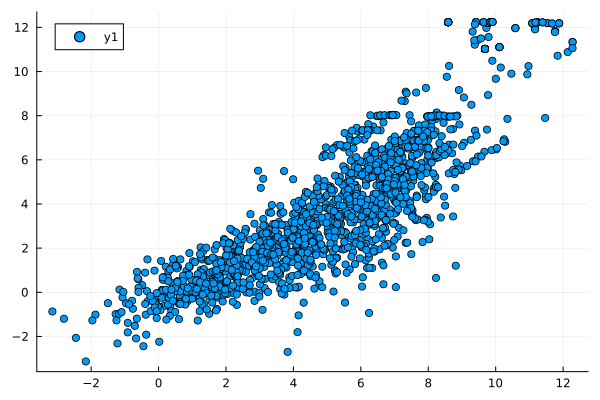

In [279]:
scatter(dEs, dEs_profile)

In [263]:
writedlm("../data_matteo/my_project/images/dms_predict_mut_time/numeric_T", numeric_T)

In [108]:
readdlm("../data_matteo/my_project/images/dms_predict_mut_time/times",'\t')
;

In [28]:
new_aa = []

for j in 1:length(start_seq)
    muts = []
    
    for i in 1:21    
        if i != start_seq[j]
        push!(muts, i)
        end
    end
    push!(new_aa, muts)
end

new_aa = vcat(new_aa...)            
old_aa = vcat([[start_seq[i] for j in 1:20] for i in 1:length(start_seq)]...)
;

In [25]:
function aa_distance(word1::String, word2::String)
    # Check if the words have the same length
    if length(word1) != length(word2)
        error("Words must have the same length.")
    end
    
    distance = 0
    
    for (char1, char2) in zip(word1, word2)
        if char1 != char2
            distance += 1
        end
    end
    
    return distance
end

function min_aa_distance(words1::Vector{String}, words2::Vector{String})
    min_distance = Inf  # Initialize with positive infinity to ensure we find a smaller distance.
    
    for word1 in words1
        for word2 in words2
            distance = aa_distance(word1, word2)
            if distance < min_distance
                min_distance = distance
                if min_distance == 1
                    return 1
                end
            end
        end
    end
    return min_distance   
end

min_aa_distance (generic function with 1 method)

In [29]:
aa_dist = [min_aa_distance(amino2cod[old_aa[i]], amino2cod[new_aa[i]]) 
        for i in 1:length(old_aa)]
;

In [30]:
aa_dist

1520-element Vector{Int64}:
 2
 2
 3
 1
 1
 2
 2
 3
 2
 3
 2
 2
 3
 ⋮
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3

In [90]:
colors_aa = aa_dist[mask]

scatter(X_filt, Ym_filt , zcolor=colors_aa, yscale=:log10,
    xlabel = "dE(a_i->a)", label = "Spearman $corr", 
    ylabel = "Tau", colorbar_title = "AA dist")
savefig("../data_matteo/my_project/images/$(tresh)dmspredictAAdist.png")

scatter(X_filt, Ym_filt ./ T_th_filt, zcolor=colors_aa, yscale=:log10,
    xlabel = "dE(a_i->a)", label = "Spearman $corr", 
    ylabel = "Tau/T_th", colorbar_title = "AA dist")
savefig("../data_matteo/my_project/images/$(tresh)T_th_dmspredictAAdist.png")




"/home/leonardo/Documents/data_matteo/my_project/images/0.2T_th_dmspredictAAdist.png"

# Simulate with fixed context

In [20]:

function model_step(mutated_seq, non_gapped_pos, h, J, N, T)
    #println("doing gibbs step")
    pos_mut = rand(non_gapped_pos)

	old_codon = mutated_seq.DNA[pos_mut]
    #println("mutating codon $(old_codon) at site $(pos_mut) ")
        
    nucleo_pos = rand(1:3)
        
    amino_list, codon_list = get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos)
    #println(amino_list, codon_list)
        
    if length(unique(amino_list)) == 1
        new_codon = rand(codon_list)
    else
        new_codon = sample(codon_list, 
            ProbabilityWeights(nucleo_cond_proba_DNA_gibbs_new(pos_mut, amino_list, 
                    codon_list, mutated_seq.Amino, h, J, N, T)))
    end
    
    #println("new codon $(new_codon) at site $(pos_mut) ")
    aa = cod2amino[new_codon]
    return aa, aa_dist(
end




function get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos::Integer)
    old_codon = [string(old_codon[i]) for i in 1:3 ]
	codon_list = Vector{AbstractString}(undef, 4)
	new_codon = deepcopy(old_codon)
	for (j, nucl) in enumerate(["A", "C", "G", "T"]) 
		new_codon[nucleo_pos] = nucl
		codon_list[j] = join(new_codon)
	end
    
    codon_list = filter!(aa->aa != "TAA", codon_list)
    codon_list = filter!(aa->aa != "TAG", codon_list)
    codon_list = filter!(aa->aa != "TGA", codon_list)
    
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	#amino_list = filter!(aa->aa != 21, amino_list)

	return amino_list, codon_list
end

function sum_couplings_inbounds(mutated_seq, q_k, k, J::Array{Float64,4}, N)
    result = 0
    @inbounds for i in 1:N
        result += J[mutated_seq[i], q_k ,i, k]
    end
    return result
end

function log_p(mutated_seq, q_k, k, J::Array{Float64,4}, N::Integer,T=1)
    #println("trying to access amino $q_k")
    log_proba = h[q_k, k]-T*log(length(amino2cod[q_k]))
    log_proba += sum_couplings_inbounds(mutated_seq, q_k, k, J, N)
    return log_proba  
end

function nucleo_cond_proba_DNA_gibbs_new(k, q, codon_list, mutated_seq, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer,  T = 1)
	prob = zeros(length(codon_list))
        
    d = Dict{Int64, Float64}()
    
	@inbounds for (index, q_k) in enumerate(q)
        #println(q)
            
        if haskey(d, q_k)
            log_proba = d[q_k]
            #println("not computed")
        else
            log_proba = log_p(mutated_seq, q_k, k, J, N, T)
            d[q_k] = log_proba
            #println("computed")
        end
		prob[index] = exp(log_proba/T)
	end
        
	return normalize(prob,1)
end

function amino_seq2dna_seq(seq)
    seq_dna=[]
    for a in seq
        push!(seq_dna, sample(amino2cod[a]))
    end
    return seq_dna
end

amino_seq2dna_seq (generic function with 1 method)

In [21]:
function simulate_time(start_seq, h, J, L, MC_steps, T = 1.0)
    taus = Matrix{Union{Int, Nothing}}(undef, 21, L)
    seed_seq = SeqToEvolve(start_seq , amino_seq2dna_seq(start_seq)) 
    mutated_seq = deepcopy(seed_seq)
    @inbounds for steps in 1: MC_steps 
        if rand() > 0.5
            #println("Mc Step: $steps")
            non_gapped_pos = [pos for (pos, amino) in enumerate(mutated_seq.Amino) 
                    if amino != 21]
            aa, pos = model_step(mutated_seq, non_gapped_pos, h, J, L, T)
            if isnothing(taus[aa, pos])
                taus[aa, pos] = steps
            end
        end  
    end 
    
    final_taus = []
    for pos in 1:L
        for amino in 1:21 
            if start_seq[pos] != amino
                if taus[amino, pos] == nothing
                    push!(final_taus, MC_steps)
                else
                    push!(final_taus, taus[amino, pos])
                end
            end
        end
    end            
        
    return final_taus
end

mutable struct SeqToEvolve
    Amino   :: Array{Int64}
    DNA :: Array{AbstractString}
end

In [48]:
function model_step2(pos_mut, seed_seq, mutated_seq, h, J, N, T = 1.0)
    #println("doing gibbs step")
    #pos_mut = rand(non_gapped_pos)

	old_codon = mutated_seq.DNA[pos_mut]
    #println("mutating codon $(old_codon) at site $(pos_mut) ")
        
    nucleo_pos = rand(1:3)
        
    amino_list, codon_list = get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos)
    #println(amino_list, codon_list)
        
    if length(unique(amino_list)) == 1
        new_codon = rand(codon_list)
    else
        new_codon = sample(codon_list, 
            ProbabilityWeights(nucleo_cond_proba_DNA_gibbs_new(pos_mut, amino_list, 
                    codon_list, mutated_seq.Amino, h, J, N, T)))
    end
    
    #println("new codon $(new_codon) at site $(pos_mut) ")
    aa = cod2amino[new_codon]
    return aa, aa_distance(new_codon, seed_seq.DNA[pos_mut])
end

model_step2 (generic function with 3 methods)

In [49]:
seed_seq = SeqToEvolve(start_seq , amino_seq2dna_seq(start_seq))
model_step2(10, seed_seq, seed_seq, h, J, L)
   

(6, 0)

In [125]:
function simulate_time2(start_seq, h, J, L, MC_steps, T = 1.0)
    taus = Matrix{Union{Float64, Nothing}}(undef, 21, L)
    seed_seq = SeqToEvolve(start_seq , amino_seq2dna_seq(start_seq)) 
    distances = Matrix{Union{Float64, Nothing}}(undef, 21, L)
    
    for i in 1:L-1
        mutated_seq = deepcopy(seed_seq)
        @inbounds for steps in 1:MC_steps 
            if rand() > 0.5
                aa, d = model_step2(i, seed_seq, mutated_seq, h, J, L, T)
                
                if isnothing(taus[aa, i])
                    #println(steps)
                    #taus[aa, i] = steps / (L^d)
                    taus[aa, i] = steps
                    distances[aa, i] = d
                    
                end
            end
        end  
    end 
    
    final_taus = []
    final_d = []
    for pos in 1:L
        for amino in 1:21 
            if start_seq[pos] != amino
                if taus[amino, pos] == nothing
                    push!(final_d, 0)
                    push!(final_taus, MC_steps)
                else
                    push!(final_taus, taus[amino, pos])
                    push!(final_d, distances[amino,pos])
                end
            end
        end
    end            
        
    return final_taus, final_d
end

simulate_time2 (generic function with 2 methods)

In [141]:
MC_steps = 40000
n_chains = 5

numeric2_T = zeros(n_chains, L*20)
aa_d = zeros(n_chains, L*20)


for i in 1:n_chains
    println(i)
    tt, dd = simulate_time2(start_seq, h, J, L, MC_steps)
    numeric2_T[i,:] = tt
    aa_d[i,:] = dd
end
        

1
2
3
4
5


In [143]:
numeric2_T = numeric2_t

5×1520 Matrix{Float64}:
 40000.0  40000.0  40000.0  40000.0  …  40000.0  40000.0  40000.0  40000.0
 40000.0  40000.0  40000.0  40000.0     40000.0  40000.0  40000.0  40000.0
 40000.0  40000.0  40000.0  26397.0     40000.0  40000.0  40000.0  40000.0
 40000.0  40000.0  40000.0  22235.0     40000.0  40000.0  40000.0  40000.0
 40000.0  40000.0  40000.0  40000.0     40000.0  40000.0  40000.0  40000.0

In [9]:
folder_path = "../data_matteo/data/files_amino_mixed_dbd_steps500000_seqs500_T1.0p0.5/"
nat_MSA = Int8.(fasta2matrix("../data_matteo/alignments/natural/DBD_alignment.uniref90.cov80.a2m"))
start_seq = Int8.(fasta2matrix(joinpath(folder_path, 
            "equil_det_bal_dbd_silico_chain_num_1_T_1.0.mixedDNA.txt" )))[1,:]
L = length(start_seq)
freqs_nat = reshape(pseudocount(first_stat(nat_MSA)), (20, L))
cie = get_entropy(freqs_nat)
cde = cont_dep_entr(start_seq, h, J)
epis_score = abs.(cie .- cde)

L = length(start_seq)

;

In [127]:
MC_steps = 500000
n_chains = 300
@time numeric_T = hcat([simulate_time(start_seq, h, J, L, MC_steps) for i in 1:n_chains]...)
;

1933.099695 seconds (6.43 G allocations: 374.747 GiB, 6.76% gc time, 0.05% compilation time)


In [84]:
deg = 1 .- [length(amino2cod[aa]) for aa in start_seq]./12
non_syn = vcat([[deg[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)
@time rho = 0.5 .* non_syn .* vec(hcat([cond_proba_with_deg(i, start_seq, h, J, L) 
            for i in 1:L]...)) ./ L 
#non-including nucleotides
#@time rho = vec(hcat([cond_proba(i, start_seq, h, J, L) for i in 1:L]...)) ./ L 

T_th = abs.(log(2) ./ log.(1 .- rho))
;

  0.933723 seconds (567.88 k allocations: 24.781 MiB, 93.27% compilation time)


In [88]:
times = readdlm("../data_matteo/my_project/images/dms_predict_mut_time/times",
    '\t')
;

In [150]:
matrix1 = [1 2; 3 4]
matrix2 = [2 2; 1 2]

# Pointwise division of matrix1 by matrix2
result_matrix = matrix1 ./ matrix2

# Display the result
println(result_matrix)

[0.5 1.0; 3.0 2.0]


In [153]:
norm = [L ^ a for a in aa_d]
;

In [160]:
#median_numeric_T = median(numeric_T, dims=2)[:]
median_numeric_T = median(numeric2_T, dims = 1)[:]
median_times = median(times, dims = 2)[:]
dEs = Float64.(dms_Potts(start_seq, h, J))
;

  0.101512 seconds (276.00 k allocations: 5.505 MiB, 72.51% compilation time)


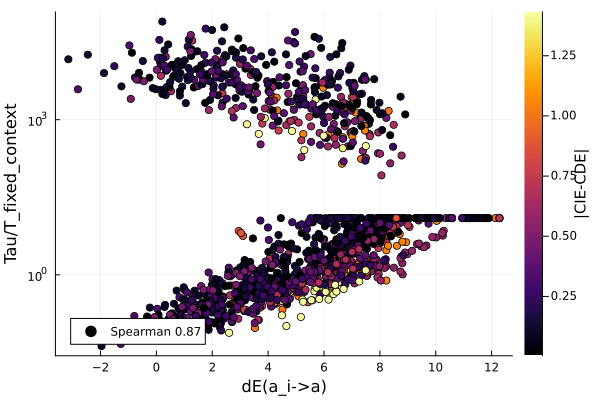

In [156]:
sat =  numeric_T.== MC_steps
sat_ab = sum(sat, dims = 2)[:] ./ length(sat[1,:])
tresh = 0.9
mask = sat_ab .< tresh

L = length(start_seq)
@time rho = vec(hcat([cond_proba_with_deg(i, start_seq, h, J, L) for i in 1:L]...)) ./ L 
T_th = abs.(log(2) ./ log.(1 .- rho))

Y = times
Ym = median(times, dims = 2)[:]

X_filt = dEs[mask]
Ym_filt = Ym[mask]
T_th_filt = T_th[mask]
numT_filt = median_numeric_T[mask]

corr = round.(corspearman(X_filt, Ym_filt), digits = 2)

colors_cde_filt = vcat([[cde[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]
colors_epis_filt = vcat([[epis_score[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]
colors_cie_filt = vcat([[cie[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]

scatter(X_filt, Ym_filt./numT_filt, zcolor=colors_epis_filt, yscale=:log10,
    xlabel = "dE(a_i->a)", label = "Spearman $corr", 
    ylabel = "Tau/T_fixed_context", colorbar_title = "|CIE-CDE|", legend=:bottomleft)

#savefig("../data_matteo/my_project/images/numT$(tresh)dmspredictepis.png")



0.89


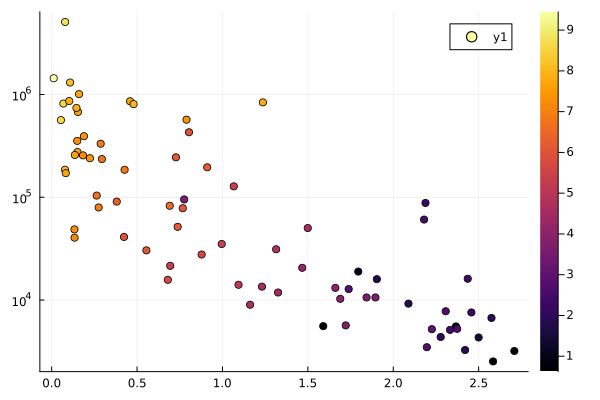

In [98]:
sat =  numeric_T.== MC_steps
sat_ab = sum(sat, dims = 2)[:] ./ length(sat[1,:])

mean_time_site = [mean(T_th[1+(i-1)*20:i*20]) for i in 1:76]
std_time_site = [std(T_th[1+(i-1)*20:i*20]) for i in 1:76]
mean_time_site_chain = [mean(median_times[1+(i-1)*20:i*20]) for i in 1:76]

dE_site = [mean(dEs[1+(i-1)*20:i*20]) for i in 1:76]

corr = round.(corspearman(dE_site, mean_time_site), digits = 2)
println(corr)
scatter(cde, mean_time_site, yscale =:log10, zcolor = dE_site)#    yscale=:log10)#yerror = std_time_site)


In [157]:
sat =  numeric_T.== MC_steps
sat_ab = sum(sat, dims = 2)[:] ./ length(sat[1,:])
tresh = 0.4
mask = sat_ab .< tresh
Y = numeric_T
Ym = median(numeric2_T, dims=2)[:]

X = times
Xm = median(times, dims=2)[:]

q1 = [quantile(Y[i,:], 0.25) for i in 1:length(Y[:,1])]
q3 = [quantile(Y[i,:], 0.75) for i in 1:length(Y[:,1])]
q1x = [quantile(X[i,:], 0.25) for i in 1:length(X[:,1])]
q3x = [quantile(X[i,:], 0.75) for i in 1:length(X[:,1])]


colors_epis_filt = vcat([[epis_score[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]
colors_cie_filt= vcat([[cde[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]
# Calculate the error bars
eps_d = Ym[mask] .- q1[mask]
eps_u= q3[mask] .- Ym[mask]

corr = round.(corspearman(Xm[mask], Ym[mask]), digits=2)

eps_dx = Xm[mask] .- q1x[mask]
eps_ux= q3x[mask] .- Xm[mask]

scatter(median_times[mask], median_numeric_T[mask], xlabel = "Tau", color=:algae,
    zcolor = colors_epis_filt, colorbar_title = "\n|CIE-CDE|", right_margin = 3Plots.mm,
    ylabel = "T_fixed_context_sim", yerror=(eps_d, eps_u), xerror=(eps_dx, eps_ux),
    xscale =:log10, yscale =:log10, label = "Spearman: $corr", legend =:bottomright,
    markerstrokecolor=:grey)
plot!([10^2,10^6], [10^2,10^6], alpha = 0.5, color =:red, label ="")
#savefig("../data_matteo/my_project/images/TauvsNumT$(tresh)epis.png")

LoadError: BoundsError: attempt to access 5-element Vector{Float64} at index [1520-element BitVector]

In [192]:
sat =  numeric_T.== MC_steps
sat_ab = sum(sat, dims = 2)[:] ./ length(sat[1,:])
tresh = 0.4
mask1 = sat_ab .< tresh
mask2 = aa_dist .== 1

mask = mask1 .& mask2

Y = numeric_T
Ym = median(numeric_T, dims=2)[:]

q1 = [quantile(Y[i,:], 0.25) for i in 1:length(Y[:,1])]
q3 = [quantile(Y[i,:], 0.75) for i in 1:length(Y[:,1])]


# Calculate the error bars
eps_d = Ym[mask] .- q1[mask]
eps_u= q3[mask] .- Ym[mask]

corr = round.(corspearman(median_numeric_T[mask], T_th[mask]), digits=2)

scatter(T_th[mask], median_numeric_T[mask], ylabel="T_fixed_context_sim", 
    yerror = (eps_d, eps_u), xlabel="T_th", label = "Spearman: $corr",
    xscale =:log10, yscale =:log10, legend =:bottomright)
savefig("../data_matteo/my_project/images/numTvsT_th$(tresh).png")

"/home/leonardo/Documents/data_matteo/my_project/images/numTvsT_th0.4.png"

In [26]:
aa_distance("AGG","AGT")

2

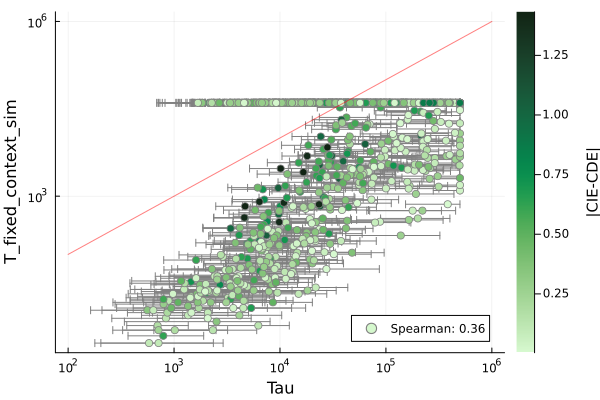

In [163]:
sat =  numeric_T.== MC_steps
sat_ab = sum(sat, dims = 2)[:] ./ length(sat[1,:])
tresh = 0.4
mask = sat_ab .< tresh
Y = numeric2_T
Ym = median_numeric_T 

X = times
Xm = median(times, dims=2)[:]

q1x = [quantile(X[i,:], 0.25) for i in 1:length(X[:,1])]
q3x = [quantile(X[i,:], 0.75) for i in 1:length(X[:,1])]


colors_epis_filt = vcat([[epis_score[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]
colors_cie_filt= vcat([[cde[i] for j in 1:20] 
        for i in 1:length(start_seq)]...)[mask]
# Calculate the error bars


corr = round.(corspearman(Xm[mask], Float64.(Ym[mask])), digits=2)

eps_dx = Xm[mask] .- q1x[mask]
eps_ux= q3x[mask] .- Xm[mask]

scatter(median_times[mask], median_numeric_T[mask], xlabel = "Tau", color=:algae,
    zcolor = colors_epis_filt, colorbar_title = "\n|CIE-CDE|", right_margin = 3Plots.mm,
    ylabel = "T_fixed_context_sim", xerror=(eps_dx, eps_ux),
    xscale =:log10, yscale =:log10, label = "Spearman: $corr", legend =:bottomright,
    markerstrokecolor=:grey)
plot!([10^2,10^6], [10^2,10^6], alpha = 0.5, color =:red, label ="")
#savefig("../data_matteo/my_project/images/TauvsNumT$(tresh)epis.png")